In [1]:
import numpy as np

In [2]:
# most recent version is here: https://github.com/NSLS-II-LIX/pyXS
from pyxs import Data2D,Mask
from pyxs.ext import RQconv 

In [3]:
def RotationMatrix(axis, angle):
    if axis=='x' or axis=='X':
        rot = np.asarray(
            [[1., 0., 0.],
             [0., np.cos(angle), -np.sin(angle)],
             [0., np.sin(angle),  np.cos(angle)]])
    elif axis=='y' or axis=='Y':
        rot = np.asarray(
            [[ np.cos(angle), 0., np.sin(angle)],
             [0., 1., 0.],
             [-np.sin(angle), 0., np.cos(angle)]])
    elif axis=='z' or axis=='Z':
        rot = np.asarray(
            [[np.cos(angle), -np.sin(angle), 0.],
             [np.sin(angle),  np.cos(angle), 0.],
             [0., 0., 1.]])
    else:
        raise ValueError('unkown axis %s' % axis)
    
    return rot 

In [4]:
class ExpPara:
    """
    The geomatric claculations used here are described in Yang, J Synch Rad (2013) 20, 211–218
    
    Initilized with image size:
    __init__(self, width, height)
    
    Calculate all coordinates and correction factors for each pixel:
    init_coordinates(self)
    
    Functions that can be called for converting coordinates (inputs are arrays)
    calc_from_XY(self, X, Y, calc_cor_factors=False)
    calc_from_QrQn(self, Qr, Qn, flag=False)
    calc_from_QPhi(self, Q, Phi)
    
    """
    wavelength = None
    bm_ctr_x = None
    bm_ctr_y = None
    ratioDw = None
    grazing_incident = False
    flip = 0
    incident_angle = 0.2
    sample_normal = 0.
    rot_matrix = None
    
    def __init__(self, width, height):
        """
        define image size here
        but fill in the coordinates later 
        """
        self.ImageWidth = width
        self.ImageHeight = height
        self.mask = Mask.Mask(width, height)

    def init_coordinates(self):
        """
        calculate all coordinates (pixel position as well as various derived values)
        all coordinates are stored in 2D arrays, as is the data itself in Data2D
        """
        (w,h) = (self.ImageWidth, self.ImageHeight)
        self.X = np.repeat(np.arange(w), h).reshape((w, h)).T
        X = self.X.flatten()
        Y = np.repeat(np.arange(h), w)
        self.Y = Y.reshape((h, w))
        
        (Q, Phi, Qr, Qn, FPol, FSA) = self.calc_from_XY(X, Y, calc_cor_factors=True)
                
        self.Q = Q.reshape((h, w))
        self.Qr = Qr.reshape((h, w))
        self.Qn = Qn.reshape((h, w))
        self.Phi = Phi.reshape((h, w))
        self.FPol = FPol.reshape((h, w))
        self.FSA = FSA.reshape((h, w))

        
    def calc_from_XY(self, X, Y, calc_cor_factors=False):
        """
        calculate Q values from pixel positions X and Y
        X and Y are 1D arrays
        returns reciprocal/angular coordinates, optionally returns 
        always calculates Qr and Qn, therefore incident_angle needs to be set 
        Note that Phi is saved in radians; but the angles in ExpPara are in degrees
        """
        if self.rot_matrix is None:
            raise ValueError('the rotation matrix is not yet set.')

        # the position vectors for each pixel, origin at the postion of beam impact
        # R.shape should be (3, w*h), but R.T is more convinient for matrix calculation
        # RT.T[i] is a vector
        RT = np.vstack((X - self.bm_ctr_x, -(Y - self.bm_ctr_y), 0.*X))
        
        dr = self.ratioDw*self.ImageWidth
        # position vectors in lab coordinates, sample at the origin
        [X1, Y1, Z1] = np.dot(self.rot_matrix, RT)
        Z1 -= dr
        
        # angles
        r3sq = X1*X1+Y1*Y1+Z1*Z1
        r3 = np.sqrt(r3sq)
        r2 = np.sqrt(X1*X1+Y1*Y1)
        Theta = 0.5*np.arcsin(r2/r3)
        Phi = np.arctan2(Y1, X1) + np.radians(self.sample_normal)

        Q = 4.0*np.pi/self.wavelength*np.sin(Theta)

        # lab coordinates
        Qz = Q*np.sin(Theta)
        Qy = Q*np.cos(Theta)*np.sin(Phi)
        Qx = Q*np.cos(Theta)*np.cos(Phi)

        # convert to sample coordinates
        alpha = np.radians(self.incident_angle)
        Qn = Qy*np.cos(alpha) + Qz*np.sin(alpha)
        Qr = np.sqrt(Q*Q-Qn*Qn)*np.sign(Qx)
        
        if calc_cor_factors==True:
            FPol = (Y1*Y1+Z1*Z1)/r3sq
            FSA = np.power(np.fabs(Z1)/r3, 3)
            return (Q, Phi, Qr, Qn, FPol, FSA)
        else:
            return (Q, Phi, Qr, Qn)
    
    def calc_from_QrQn(self, Qr, Qn, flag=False):
        """
        Qr and Qn are 1D arrays 
        when flag is True, substitue Qr with the minimal Qr value at the given Qz allowed by scattering geometry
        returns the pixel positions corresponding to (Qr, Qn)
        note that the return arrays may contain non-numerical values
        """
        if self.rot_matrix is None:
            raise ValueError('the rotation matrix is not yet set.')
                    
        alpha = np.radians(self.incident_angle)
        
        if flag is True:
            k = 2.0*np.pi/self.wavelength
            tt = Qn/k -np.sin(alpha)
            Qr0 = np.empty(len(Qr))
            Qr0[tt<=1.] = np.fabs(np.sqrt(1.-(tt*tt)[tt<=1.]) - np.cos(alpha))*k
            idx1 = (Qr<Qr0) & (tt<=1.)
            Qr[idx1] = Qr0[idx1]*np.sign(Qr[idx1])

        Q = np.sqrt(Qr*Qr+Qn*Qn)
        Phi = np.empty(len(Q))

        Theta = self.wavelength*Q/(4.0*np.pi)
        idx = (Theta<=1.0)
        Theta = np.arcsin(Theta[idx])
        Phi[~idx] = np.nan
        
        Qz = Q[idx]*np.sin(Theta)
        Qy = (Qn[idx] - Qz*np.sin(alpha)) / np.cos(alpha)
        tt = Q[idx]*Q[idx] - Qz*Qz - Qy*Qy
        idx2 = (tt>=0)
        Qx = np.empty(len(Q[idx]))
        Qx[idx2] = np.sqrt(tt[idx2])*np.sign(Qr[idx][idx2])
        
        Phi[idx & idx2] = np.arctan2(Qy[idx2], Qx[idx2]) 
        Phi[idx & ~idx2] = np.nan

        return self.calc_from_QPhi(Q, Phi)    

    def calc_from_QPhi(self, Q, Phi):
        """
        Q and Phi are 1D arrays 
        Phi=0 is the y-axis (pointing up), unless sample_normal is non-zero
        returns the pixel positions corresponding to (Q, Phi)
        note that the return arrays may contain non-numerical values
        """
        if self.rot_matrix is None:
            raise ValueError('the rotation matrix is not yet set.')
        

        Theta = self.wavelength*Q/(4.0*np.pi)
        X0 = np.empty(len(Theta))
        Y0 = np.empty(len(Theta))
        
        idx = (Theta<=1.0) & (~np.isnan(Phi))  # Phi might contain nan from calc_from_QrQn()
        Theta = np.arcsin(Theta[idx]);
        
        Phi = Phi[idx] - np.radians(self.sample_normal)

        [R13, R23, R33] = np.dot(self.rot_matrix, np.asarray([0., 0., 1.]))

        dr = self.ratioDw*self.ImageWidth

        # pixel position in lab referece frame, both centered on detector
        # this is code from RQconv.c
        # In comparison, the coordinates in equ(18) in the reference above are centered at the sample
        tt = (R13*np.cos(Phi)+R23*np.sin(Phi))*np.tan(2.0*Theta)
        Z1 = dr*tt/(tt-R33);
        X1 = (dr-Z1)*np.tan(2.0*Theta)*np.cos(Phi);
        Y1 = (dr-Z1)*np.tan(2.0*Theta)*np.sin(Phi);
        
        R1 = np.vstack((X1, Y1, Z1))
        
        # transform to detector frame
        [X, Y, Z] = np.dot(self.rot_matrix.T, R1);

        # pixel position, note reversed y-axis
        X0[idx] = X + self.bm_ctr_x
        Y0[idx] = -Y + self.bm_ctr_y
        X0[~idx] = np.nan
        Y0[~idx] = np.nan
        
        return (X0, Y0)
    
class ExpParaLiX(ExpPara):
    """
    This is one way to define the orientation of the detector, as defined in the ref above
    The detector orientation can be defined by a different set of angles
    A different derived class can be defined to inherent the same fuctions from ExpPara 
    """
    det_orient = 0.
    det_tilt = 0.
    det_phi = 0.
    
    def calc_rot_matrix(self):
        tm1 = RotationMatrix('z', np.radians(-self.det_orient))
        tm2 = RotationMatrix('y', np.radians(self.det_tilt))
        tm3 = RotationMatrix('z', np.radians(self.det_orient+self.det_phi))
        self.rot_matrix = np.dot(np.dot(tm3, tm2), tm1)
        

In [5]:
ep = ExpParaLiX(619, 487)    # WAXS1, with crazy angles

ene = 11384.26
wl = 2.*np.pi*1973/ene
ep.wavelength = wl
ep.det_orient = 30.
ep.det_tilt = -26.
ep.det_phi = -40.
ep.bm_ctr_x = -141.
ep.bm_ctr_y = 328.3
ep.ratioDw = 2.86
ep.grazing_incident = False
ep.flip = 1
ep.incident_angle = 2.0
ep.sample_normal = 0

ep.calc_rot_matrix()
ep.init_coordinates()

In [6]:
ew1 = RQconv.ExpPara()

ew1.wavelength = wl
ew1.bm_ctr_x = -141.    
ew1.bm_ctr_y = 328.3   
ew1.ratioDw = 2.86
ew1.det_orient = 30.
ew1.det_tilt = -26.
ew1.det_phi = -40.
ew1.grazing_incident = False
ew1.flip = 1
ew1.incident_angle = 2.0
ew1.sample_normal = 0

In [7]:
# data from Pilatus 300K
dw1 = Data2D.Data2d("ru30_2_000018_WAXS1.cbf")
dw1.set_exp_para(ew1)

In [8]:
(i,j) = (99, 21) 
print(ep.X[i,j],ep.Y[i,j])
print(dw1.xy2qrqz(np.float(ep.X[i,j]),np.float(ep.Y[i,j])))
print(ep.Qr[i,j], ep.Qn[i,j])

21 99
(0.8480165600776672, 0.263500452041626)
0.848016669689 0.26350051475


In [9]:
%matplotlib notebook
import pylab as plt

<IPython.core.display.Javascript object>


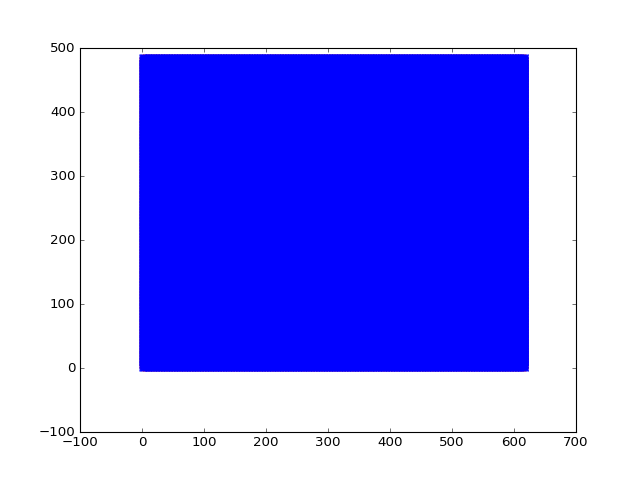

In [10]:
xx, yy = ep.calc_from_QrQn(ep.Qr.flatten(), ep.Qn.flatten())
plt.figure()
plt.plot(xx, yy, 'r+')
plt.plot(ep.X.flatten(), ep.Y.flatten(), 'x')

<IPython.core.display.Javascript object>


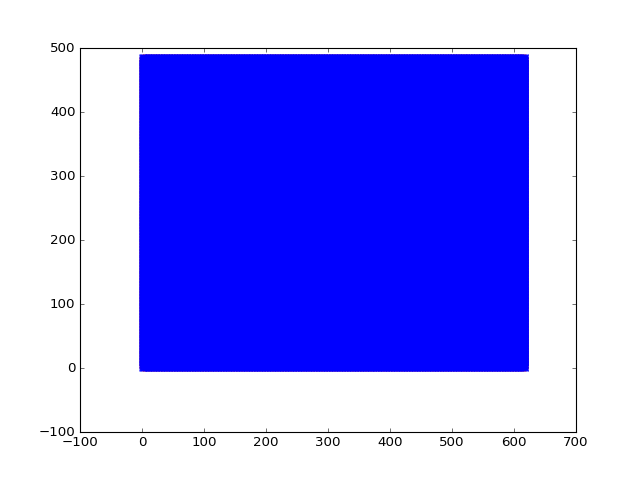

In [11]:
xx, yy = ep.calc_from_QPhi(ep.Q.flatten(), ep.Phi.flatten())
plt.figure()
plt.plot(xx, yy, 'r+')
plt.plot(ep.X.flatten(), ep.Y.flatten(), 'x')